In [52]:
import logging
import time
from typing import List, Dict, Optional

import numpy as np
import pandas as pd
import yfinance as yf

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


def fetch_history_bulk(
    tickers: List[str],
    pause: float = 1.0
) -> pd.DataFrame:
    """
    Fetches max‐history daily data for multiple tickers in one call.
    """
    # This returns a nested DataFrame: columns=(ticker, field)
    raw = yf.download(
        tickers,
        period="max",
        interval="1d",
        group_by="ticker",
        auto_adjust=False,
        threads=True,
        progress=False,
    )
    # Unstack into long form
    frames = []
    for ticker in tickers:
        if ticker not in raw.columns.levels[0]:
            logger.warning("No data for %s", ticker)
            continue

        df = raw[ticker].copy()
        df = df.rename_axis("Date").reset_index()
        df.loc[:, "Ticker"] = ticker
        frames.append(df)

        time.sleep(pause)  # to be gentle on the API

    return pd.concat(frames, ignore_index=True)


def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.loc[:, "Date"] = pd.to_datetime(df["Date"])
    df.loc[:, "Year"]    = df["Date"].dt.year
    df.loc[:, "Month"]   = df["Date"].dt.month
    df.loc[:, "Weekday"] = df["Date"].dt.weekday
    df.loc[:, "wom"] = ((df["Date"].dt.day - 1) // 7 + 1).astype(int)
    df.loc[:, "month_wom"] = (
        df["Date"].dt.month_name() + "_w" + df["wom"].astype(str)
    )
    return df


def add_growth_features(
    df: pd.DataFrame,
    lookbacks: List[int] = [1, 3, 7, 30, 90, 252, 365],
    horizons: List[int] = [30],
    binarize_thresholds: Optional[Dict[int, float]] = None
) -> pd.DataFrame:
    df = df.copy()
    # 1) historical growth
    for j in lookbacks:
        df[f"growth_{j}d"] = df["Close"] / df["Close"].shift(j)

    # 2) forward‐looking growth
    for h in horizons:
        df[f"growth_future_{h}d"] = df["Close"].shift(-h) / df["Close"]

    # 3) optional binarization
    if binarize_thresholds:
        for h, thresh in binarize_thresholds.items():
            if h not in horizons:
                raise ValueError(f"horizon {h} not in `horizons` list")
            col = f"growth_future_{h}d"
            df[f"is_positive_future_{h}d"] = (df[col] > thresh).astype(int)

    return df


def add_moving_averages(
    df: pd.DataFrame,
    windows: List[int] = [10, 20]
) -> pd.DataFrame:
    df = df.copy()
    for w in windows:
        df[f"SMA{w}"] = df["Close"].rolling(w).mean()
    if len(windows) >= 2:
        df.loc[:, "growing_moving_average"] = (
            df[f"SMA{windows[0]}"] > df[f"SMA{windows[1]}"]
        ).astype(int)
    return df


def add_volatility_and_sharpe(
    df: pd.DataFrame,
    vol_window: int = 30,
    risk_free: float = 0.045
) -> pd.DataFrame:
    df = df.copy()
    df.loc[:, "volatility"] = (
        df["Close"].pct_change(fill_method=None).rolling(vol_window).std() * np.sqrt(252)
    )
    if "growth_252d" not in df.columns:
        df.loc[:, "growth_252d"] = df["Close"] / df["Close"].shift(252)
    df.loc[:, "Sharpe"] = (df["growth_252d"] - risk_free) / df["volatility"]
    return df


def add_price_range(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.loc[:, "high_minus_low_relative"] = (
        (df["High"] - df["Low"]) / df["Close"]
    )
    return df


def build_stock_dataframe(
    tickers: List[str],
    lookbacks: List[int] = [1, 3, 7, 30, 90, 252, 365],
    horizons: List[int] = [30],
    binarize_thresholds: Optional[Dict[int, float]] = None,
    ma_windows: List[int] = [10, 20],
    vol_window: int = 30,
    risk_free: float = 0.045,
    pause: float = 1.0
) -> pd.DataFrame:
    """
    Fetches history for `tickers`, applies all feature pipelines,
    and returns a cleaned, sorted DataFrame.
    """
    df_all = fetch_history_bulk(tickers, pause=pause)

    df_all = (
        df_all
        .pipe(add_time_features)
        .pipe(add_growth_features, lookbacks, horizons, binarize_thresholds)
        .pipe(add_moving_averages, ma_windows)
        .pipe(add_volatility_and_sharpe, vol_window, risk_free)
        .pipe(add_price_range)
    )

    # drop rows with NaN in any of the raw future targets
    future_cols = [f"growth_future_{h}d" for h in horizons]
    df_all.dropna(subset=future_cols, inplace=True)

    # final ordering & reset
    df_all.sort_values(["Ticker", "Date"], inplace=True)
    df_all.reset_index(drop=True, inplace=True)
    return df_all


def build_stock_dataframe(
    tickers: List[str],
    lookbacks: List[int] = [1, 3, 7, 30, 90, 252, 365],
    horizons: List[int] = [30],
    binarize_thresholds: Optional[Dict[int, float]] = None,
    ma_windows: List[int] = [10, 20],
    vol_window: int = 30,
    risk_free: float = 0.045,
    pause: float = 1.0
) -> pd.DataFrame:
    """
    Fetches history for `tickers`, applies all feature pipelines,
    and returns a cleaned, sorted DataFrame.
    """
    df_all = fetch_history_bulk(tickers, pause=pause)

    df_all = (
        df_all
        .pipe(add_time_features)
        .pipe(add_growth_features, lookbacks, horizons, binarize_thresholds)
        .pipe(add_moving_averages, ma_windows)
        .pipe(add_volatility_and_sharpe, vol_window, risk_free)
        .pipe(add_price_range)
    )

    # Only drop nulls from historical data, preserve recent data
    future_cols = [f"growth_future_{h}d" for h in horizons]
    if future_cols:
        max_horizon = max(horizons)
        cutoff_date = df_all['Date'].max() - pd.Timedelta(days=max_horizon + 5)
        
        # Keep recent data even with null future columns
        recent_mask = df_all['Date'] > cutoff_date
        df_all = pd.concat([
            df_all[~recent_mask].dropna(subset=future_cols),  # Clean historical data
            df_all[recent_mask]  # Preserve recent data
        ], ignore_index=True)

    # final ordering & reset
    df_all.sort_values(["Ticker", "Date"], inplace=True)
    df_all.reset_index(drop=True, inplace=True)
    return df_all

# --- Usage Example ---
if __name__ == "__main__":
    tickers = ["AAPL", "MSFT"]
    stocks_df = build_stock_dataframe(
        tickers,
        lookbacks=[1,3,7,30,90,252,365],
        horizons=[30],
        binarize_thresholds={30: 1.0},
        ma_windows=[10, 20],
        vol_window=30,
        risk_free=0.045,
        pause=0.5
    )
    stocks_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21122 entries, 0 to 21121
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     21122 non-null  datetime64[ns]
 1   Open                     21122 non-null  float64       
 2   High                     21122 non-null  float64       
 3   Low                      21122 non-null  float64       
 4   Close                    21122 non-null  float64       
 5   Adj Close                21122 non-null  float64       
 6   Volume                   21122 non-null  float64       
 7   Ticker                   21122 non-null  object        
 8   Year                     21122 non-null  int32         
 9   Month                    21122 non-null  int32         
 10  Weekday                  21122 non-null  int32         
 11  wom                      21122 non-null  int64         
 12  month_wom                21122 n

In [53]:
stocks_df.tail()

Price,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,...,growth_252d,growth_365d,growth_future_30d,is_positive_future_30d,SMA10,SMA20,growing_moving_average,volatility,Sharpe,high_minus_low_relative
21117,2025-06-27,497.549988,499.299988,493.029999,495.940002,495.940002,34539200.0,MSFT,2025,6,...,1.099767,1.289395,NaN,0,485.154999,476.696999,1,0.125808,8.383942,0.012643
21118,2025-06-30,497.040009,500.760010,495.329987,497.410004,497.410004,28369000.0,MSFT,2025,6,...,1.100075,1.280434,NaN,0,487.400000,478.549500,1,0.125560,8.402942,0.010917
21119,2025-07-01,496.470001,498.049988,490.980011,492.049988,492.049988,19945400.0,MSFT,2025,7,...,1.086563,1.260794,NaN,0,488.690997,480.053499,1,0.131887,7.897381,0.014368
21120,2025-07-02,489.989990,493.500000,488.700012,491.089996,491.089996,16319600.0,MSFT,2025,7,...,1.098758,1.260919,NaN,0,489.995996,481.459499,1,0.130616,8.067574,0.009774
21121,2025-07-03,493.809998,500.130005,493.440002,498.839996,498.839996,13984800.0,MSFT,2025,7,...,1.092199,1.266509,NaN,0,491.855997,483.207999,1,0.135746,7.714419,0.013411


In [54]:
import pandas as pd

# After your global sort…
stocks_df.sort_values(["Ticker","Date"], inplace=True)

# Check each ticker’s date sequence
bad = (
    stocks_df
    .groupby("Ticker")["Date"]
    .apply(lambda idx: not idx.is_monotonic_increasing)
    .loc[lambda s: s]
)
print("Tickers with non-increasing dates:", bad.index.tolist())


Tickers with non-increasing dates: []


In [7]:
import talib

## Momentum indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/momentum_indicators.md

In [8]:
def talib_get_momentum_indicators_for_one_ticker(df: pd.DataFrame) -> pd.DataFrame:
  # ADX - Average Directional Movement Index
  talib_momentum_adx = talib.ADX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # ADXR - Average Directional Movement Index Rating
  talib_momentum_adxr = talib.ADXR(df.High.values, df.Low.values, df.Close.values, timeperiod=14 )
  # APO - Absolute Price Oscillator
  talib_momentum_apo = talib.APO(df.Close.values, fastperiod=12, slowperiod=26, matype=0 )
  # AROON - Aroon
  talib_momentum_aroon = talib.AROON(df.High.values, df.Low.values, timeperiod=14 )
  # talib_momentum_aroon[0].size
  # talib_momentum_aroon[1].size
  # AROONOSC - Aroon Oscillator
  talib_momentum_aroonosc = talib.AROONOSC(df.High.values, df.Low.values, timeperiod=14)
  # BOP - Balance of Power
  # https://school.stockcharts.com/doku.php?id=technical_indicators:balance_of_power
     #calculate open prices as shifted closed prices from the prev day
     # open = df.Last.shift(1)
  talib_momentum_bop = talib.BOP(df.Open.values, df.High.values, df.Low.values, df.Close.values)
  # CCI - Commodity Channel Index
  talib_momentum_cci = talib.CCI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # CMO - Chande Momentum Oscillator
  talib_momentum_cmo = talib.CMO(df.Close.values, timeperiod=14)
  # DX - Directional Movement Index
  talib_momentum_dx = talib.DX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # MACD - Moving Average Convergence/Divergence
  talib_momentum_macd, talib_momentum_macdsignal, talib_momentum_macdhist = talib.MACD(df.Close.values, fastperiod=12, \
                                                                                       slowperiod=26, signalperiod=9)
  # MACDEXT - MACD with controllable MA type
  talib_momentum_macd_ext, talib_momentum_macdsignal_ext, talib_momentum_macdhist_ext = talib.MACDEXT(df.Close.values, \
                                                                                                    fastperiod=12, \
                                                                                                    fastmatype=0, \
                                                                                                    slowperiod=26, \
                                                                                                    slowmatype=0, \
                                                                                                    signalperiod=9, \
                                                                                                  signalmatype=0)
  # MACDFIX - Moving Average Convergence/Divergence Fix 12/26
  talib_momentum_macd_fix, talib_momentum_macdsignal_fix, talib_momentum_macdhist_fix = talib.MACDFIX(df.Close.values, \
                                                                                                      signalperiod=9)
  # MFI - Money Flow Index
  talib_momentum_mfi = talib.MFI(df.High.values, df.Low.values, df.Close.values, df.Volume.values, timeperiod=14)
  # MINUS_DI - Minus Directional Indicator
  talib_momentum_minus_di = talib.MINUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # MOM - Momentum
  talib_momentum_mom = talib.MOM(df.Close.values, timeperiod=10)
  # PLUS_DI - Plus Directional Indicator
  talib_momentum_plus_di = talib.PLUS_DI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # PLUS_DM - Plus Directional Movement
  talib_momentum_plus_dm = talib.PLUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # PPO - Percentage Price Oscillator
  talib_momentum_ppo = talib.PPO(df.Close.values, fastperiod=12, slowperiod=26, matype=0)
  # ROC - Rate of change : ((price/prevPrice)-1)*100
  talib_momentum_roc = talib.ROC(df.Close.values, timeperiod=10)
  # ROCP - Rate of change Percentage: (price-prevPrice)/prevPrice
  talib_momentum_rocp = talib.ROCP(df.Close.values, timeperiod=10)
  # ROCR - Rate of change ratio: (price/prevPrice)
  talib_momentum_rocr = talib.ROCR(df.Close.values, timeperiod=10)
  # ROCR100 - Rate of change ratio 100 scale: (price/prevPrice)*100
  talib_momentum_rocr100 = talib.ROCR100(df.Close.values, timeperiod=10)
  # RSI - Relative Strength Index
  talib_momentum_rsi = talib.RSI(df.Close.values, timeperiod=14)
  # STOCH - Stochastic
  talib_momentum_slowk, talib_momentum_slowd = talib.STOCH(df.High.values, df.Low.values, df.Close.values, \
                                                           fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
  # STOCHF - Stochastic Fast
  talib_momentum_fastk, talib_momentum_fastd = talib.STOCHF(df.High.values, df.Low.values, df.Close.values, \
                                                            fastk_period=5, fastd_period=3, fastd_matype=0)
  # STOCHRSI - Stochastic Relative Strength Index
  talib_momentum_fastk_rsi, talib_momentum_fastd_rsi = talib.STOCHRSI(df.Close.values, timeperiod=14, \
                                                                      fastk_period=5, fastd_period=3, fastd_matype=0)
  # TRIX - 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA
  talib_momentum_trix = talib.TRIX(df.Close.values, timeperiod=30)
  # ULTOSC - Ultimate Oscillator
  talib_momentum_ultosc = talib.ULTOSC(df.High.values, df.Low.values, df.Close.values, timeperiod1=7, timeperiod2=14, timeperiod3=28)
  # WILLR - Williams' %R
  talib_momentum_willr = talib.WILLR(df.High.values, df.Low.values, df.Close.values, timeperiod=14)

  momentum_df =   pd.DataFrame(
    {
      # assume here multi-index <dateTime, ticker>
      # 'datetime': df.index.get_level_values(0),
      # 'ticker': df.index.get_level_values(1) ,

      # old way with separate columns
      'Date': df.Date.values,
      'Ticker': df.Ticker,

      'adx': talib_momentum_adx,
      'adxr': talib_momentum_adxr,
      'apo': talib_momentum_apo,
      'aroon_1': talib_momentum_aroon[0] ,
      'aroon_2': talib_momentum_aroon[1],
      'aroonosc': talib_momentum_aroonosc,
      'bop': talib_momentum_bop,
      'cci': talib_momentum_cci,
      'cmo': talib_momentum_cmo,
      'dx': talib_momentum_dx,
      'macd': talib_momentum_macd,
      'macdsignal': talib_momentum_macdsignal,
      'macdhist': talib_momentum_macdhist,
      'macd_ext': talib_momentum_macd_ext,
      'macdsignal_ext': talib_momentum_macdsignal_ext,
      'macdhist_ext': talib_momentum_macdhist_ext,
      'macd_fix': talib_momentum_macd_fix,
      'macdsignal_fix': talib_momentum_macdsignal_fix,
      'macdhist_fix': talib_momentum_macdhist_fix,
      'mfi': talib_momentum_mfi,
      'minus_di': talib_momentum_minus_di,
      'mom': talib_momentum_mom,
      'plus_di': talib_momentum_plus_di,
      'dm': talib_momentum_plus_dm,
      'ppo': talib_momentum_ppo,
      'roc': talib_momentum_roc,
      'rocp': talib_momentum_rocp,
      'rocr': talib_momentum_rocr,
      'rocr100': talib_momentum_rocr100,
      'rsi': talib_momentum_rsi,
      'slowk': talib_momentum_slowk,
      'slowd': talib_momentum_slowd,
      'fastk': talib_momentum_fastk,
      'fastd': talib_momentum_fastd,
      'fastk_rsi': talib_momentum_fastk_rsi,
      'fastd_rsi': talib_momentum_fastd_rsi,
      'trix': talib_momentum_trix,
      'ultosc': talib_momentum_ultosc,
      'willr': talib_momentum_willr,
     }
  )
  return momentum_df

## Volume, Volatility, Cycle, Price indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volume_indicators.md

In [9]:
def talib_get_volume_volatility_cycle_price_indicators(df: pd.DataFrame) -> pd.DataFrame:
        # TA-Lib Volume indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volume_indicators.md
        # AD - Chaikin A/D Line
        talib_ad = talib.AD(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values)
        # ADOSC - Chaikin A/D Oscillator
        talib_adosc = talib.ADOSC(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values, fastperiod=3, slowperiod=10)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Volatility indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volatility_indicators.md
        # ATR - Average True Range
        talib_atr = talib.ATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # NATR - Normalized Average True Range
        talib_natr = talib.NATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Cycle Indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/cycle_indicators.md
        # HT_DCPERIOD - Hilbert Transform - Dominant Cycle Period
        talib_ht_dcperiod = talib.HT_DCPERIOD(df.Close.values)
        # HT_DCPHASE - Hilbert Transform - Dominant Cycle Phase
        talib_ht_dcphase = talib.HT_DCPHASE(df.Close.values)
        # HT_PHASOR - Hilbert Transform - Phasor Components
        talib_ht_phasor_inphase, talib_ht_phasor_quadrature = talib.HT_PHASOR(
            df.Close.values)
        # HT_SINE - Hilbert Transform - SineWave
        talib_ht_sine_sine, talib_ht_sine_leadsine = talib.HT_SINE(
            df.Close.values)
        # HT_TRENDMODE - Hilbert Transform - Trend vs Cycle Mode
        talib_ht_trendmode = talib.HT_TRENDMODE(df.Close.values)

        # TA-Lib Price Transform Functions
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/price_transform.md
        # AVGPRICE - Average Price
        talib_avgprice = talib.AVGPRICE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # MEDPRICE - Median Price
        talib_medprice = talib.MEDPRICE(df.High.values, df.Low.values)
        # TYPPRICE - Typical Price
        talib_typprice = talib.TYPPRICE(
            df.High.values, df.Low.values, df.Close.values)
        # WCLPRICE - Weighted Close Price
        talib_wclprice = talib.WCLPRICE(
            df.High.values, df.Low.values, df.Close.values)

        volume_volatility_cycle_price_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Volume indicators
             'ad': talib_ad,
             'adosc': talib_adosc,
             'obv': talib_obv,
             # TA-Lib Volatility indicators
             'atr': talib_atr,
             'natr': talib_natr,
             'obv': talib_obv,
             # TA-Lib Cycle Indicators
             'ht_dcperiod': talib_ht_dcperiod,
             'ht_dcphase': talib_ht_dcphase,
             'ht_phasor_inphase': talib_ht_phasor_inphase,
             'ht_phasor_quadrature': talib_ht_phasor_quadrature,
             'ht_sine_sine': talib_ht_sine_sine,
             'ht_sine_leadsine': talib_ht_sine_leadsine,
             'ht_trendmod': talib_ht_trendmode,
             # TA-Lib Price Transform Functions
             'avgprice': talib_avgprice,
             'medprice': talib_medprice,
             'typprice': talib_typprice,
             'wclprice': talib_wclprice,
             }
        )

        # Need a proper date type
        volume_volatility_cycle_price_df['Date'] = pd.to_datetime(
            volume_volatility_cycle_price_df['Date'])

        return volume_volatility_cycle_price_df

## Pattern indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/pattern_recognition.md

In [13]:
def talib_get_pattern_recognition_indicators(df: pd.DataFrame) -> pd.DataFrame:
# TA-Lib Pattern Recognition indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/pattern_recognition.md
        # Nice article about candles (pattern recognition) https://medium.com/analytics-vidhya/recognizing-over-50-candlestick-patterns-with-python-4f02a1822cb5

        # CDL2CROWS - Two Crows
        talib_cdl2crows = talib.CDL2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3BLACKCROWS - Three Black Crows
        talib_cdl3blackrows = talib.CDL3BLACKCROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3INSIDE - Three Inside Up/Down
        talib_cdl3inside = talib.CDL3INSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3LINESTRIKE - Three-Line Strike
        talib_cdl3linestrike = talib.CDL3LINESTRIKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3OUTSIDE - Three Outside Up/Down
        talib_cdl3outside = talib.CDL3OUTSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3STARSINSOUTH - Three Stars In The South
        talib_cdl3starsinsouth = talib.CDL3STARSINSOUTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3WHITESOLDIERS - Three Advancing White Soldiers
        talib_cdl3whitesoldiers = talib.CDL3WHITESOLDIERS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLABANDONEDBABY - Abandoned Baby
        talib_cdlabandonedbaby = talib.CDLABANDONEDBABY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLADVANCEBLOCK - Advance Block
        talib_cdladvancedblock = talib.CDLADVANCEBLOCK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBELTHOLD - Belt-hold
        talib_cdlbelthold = talib.CDLBELTHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBREAKAWAY - Breakaway
        talib_cdlbreakaway = talib.CDLBREAKAWAY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCLOSINGMARUBOZU - Closing Marubozu
        talib_cdlclosingmarubozu = talib.CDLCLOSINGMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCONCEALBABYSWALL - Concealing Baby Swallow
        talib_cdlconcealbabyswall = talib.CDLCONCEALBABYSWALL(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCOUNTERATTACK - Counterattack
        talib_cdlcounterattack = talib.CDLCOUNTERATTACK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDARKCLOUDCOVER - Dark Cloud Cover
        talib_cdldarkcloudcover = talib.CDLDARKCLOUDCOVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLDOJI - Doji
        talib_cdldoji = talib.CDLDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDOJISTAR - Doji Star
        talib_cdldojistar = talib.CDLDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDRAGONFLYDOJI - Dragonfly Doji
        talib_cdldragonflydoji = talib.CDLDRAGONFLYDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLENGULFING - Engulfing Pattern
        talib_cdlengulfing = talib.CDLENGULFING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLEVENINGDOJISTAR - Evening Doji Star
        talib_cdleveningdojistar = talib.CDLEVENINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLEVENINGSTAR - Evening Star
        talib_cdleveningstar = talib.CDLEVENINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLGAPSIDESIDEWHITE - Up/Down-gap side-by-side white lines
        talib_cdlgapsidesidewhite = talib.CDLGAPSIDESIDEWHITE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLGRAVESTONEDOJI - Gravestone Doji
        talib_cdlgravestonedoji = talib.CDLGRAVESTONEDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHAMMER - Hammer
        talib_cdlhammer = talib.CDLHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHANGINGMAN - Hanging Man
        talib_cdlhangingman = talib.CDLHANGINGMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMI - Harami Pattern
        talib_cdlharami = talib.CDLHARAMI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMICROSS - Harami Cross Pattern
        talib_cdlharamicross = talib.CDLHARAMICROSS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIGHWAVE - High-Wave Candle
        talib_cdlhighwave = talib.CDLHIGHWAVE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKE - Hikkake Pattern
        talib_cdlhikkake = talib.CDLHIKKAKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKEMOD - Modified Hikkake Pattern
        talib_cdlhikkakemod = talib.CDLHIKKAKEMOD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLHOMINGPIGEON - Homing Pigeon
        talib_cdlhomingpigeon = talib.CDLHOMINGPIGEON(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLIDENTICAL3CROWS - Identical Three Crows
        talib_cdlidentical3crows = talib.CDLIDENTICAL3CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINNECK - In-Neck Pattern
        talib_cdlinneck = talib.CDLINNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINVERTEDHAMMER - Inverted Hammer
        talib_cdlinvertedhammer = talib.CDLINVERTEDHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKING - Kicking
        talib_cdlkicking = talib.CDLKICKING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKINGBYLENGTH - Kicking - bull/bear determined by the longer marubozu
        talib_cdlkickingbylength = talib.CDLKICKINGBYLENGTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLADDERBOTTOM - Ladder Bottom
        talib_cdlladderbottom = talib.CDLLADDERBOTTOM(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLEGGEDDOJI - Long Legged Doji
        talib_cdllongleggeddoji = talib.CDLLONGLEGGEDDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLINE - Long Line Candle
        talib_cdllongline = talib.CDLLONGLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMARUBOZU - Marubozu
        talib_cdlmarubozu = talib.CDLMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMATCHINGLOW - Matching Low
        talib_cdlmatchinglow = talib.CDLMATCHINGLOW(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLMATHOLD - Mat Hold
        talib_cdlmathold = talib.CDLMATHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGDOJISTAR - Morning Doji Star
        talib_cdlmorningdojistar = talib.CDLMORNINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGSTAR - Morning Star
        talib_cdlmorningstar = talib.CDLMORNINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLONNECK - On-Neck Pattern
        talib_cdlonneck = talib.CDLONNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLPIERCING - Piercing Pattern
        talib_cdlpiercing = talib.CDLPIERCING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRICKSHAWMAN - Rickshaw Man
        talib_cdlrickshawman = talib.CDLRICKSHAWMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRISEFALL3METHODS - Rising/Falling Three Methods
        talib_cdlrisefall3methods = talib.CDLRISEFALL3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSEPARATINGLINES - Separating Lines
        talib_cdlseparatinglines = talib.CDLSEPARATINGLINES(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHOOTINGSTAR - Shooting Star
        talib_cdlshootingstar = talib.CDLSHOOTINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHORTLINE - Short Line Candle
        talib_cdlshortline = talib.CDLSHORTLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSPINNINGTOP - Spinning Top
        talib_cdlspinningtop = talib.CDLSPINNINGTOP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLSTALLEDPATTERN - Stalled Pattern
        talib_cdlstalledpattern = talib.CDLSTALLEDPATTERN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSTICKSANDWICH - Stick Sandwich
        talib_cdlsticksandwich = talib.CDLSTICKSANDWICH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTAKURI - Takuri (Dragonfly Doji with very long lower shadow)
        talib_cdltakuru = talib.CDLTAKURI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTASUKIGAP - Tasuki Gap
        talib_cdltasukigap = talib.CDLTASUKIGAP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTHRUSTING - Thrusting Pattern
        talib_cdlthrusting = talib.CDLTHRUSTING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTRISTAR - Tristar Pattern
        talib_cdltristar = talib.CDLTRISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUNIQUE3RIVER - Unique 3 River
        talib_cdlunique3river = talib.CDLUNIQUE3RIVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUPSIDEGAP2CROWS - Upside Gap Two Crows
        talib_cdlupsidegap2crows = talib.CDLUPSIDEGAP2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLXSIDEGAP3METHODS - Upside/Downside Gap Three Methods
        talib_cdlxsidegap3methods = talib.CDLXSIDEGAP3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        pattern_indicators_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Pattern Recognition indicators
             'cdl2crows': talib_cdl2crows,
             'cdl3blackrows': talib_cdl3blackrows,
             'cdl3inside': talib_cdl3inside,
             'cdl3linestrike': talib_cdl3linestrike,
             'cdl3outside': talib_cdl3outside,
             'cdl3starsinsouth': talib_cdl3starsinsouth,
             'cdl3whitesoldiers': talib_cdl3whitesoldiers,
             'cdlabandonedbaby': talib_cdlabandonedbaby,
             'cdladvancedblock': talib_cdladvancedblock,
             'cdlbelthold': talib_cdlbelthold,
             'cdlbreakaway': talib_cdlbreakaway,
             'cdlclosingmarubozu': talib_cdlclosingmarubozu,
             'cdlconcealbabyswall': talib_cdlconcealbabyswall,
             'cdlcounterattack': talib_cdlcounterattack,
             'cdldarkcloudcover': talib_cdldarkcloudcover,
             'cdldoji': talib_cdldoji,
             'cdldojistar': talib_cdldojistar,
             'cdldragonflydoji': talib_cdldragonflydoji,
             'cdlengulfing': talib_cdlengulfing,
             'cdleveningdojistar': talib_cdleveningdojistar,
             'cdleveningstar': talib_cdleveningstar,
             'cdlgapsidesidewhite': talib_cdlgapsidesidewhite,
             'cdlgravestonedoji': talib_cdlgravestonedoji,
             'cdlhammer': talib_cdlhammer,
             'cdlhangingman': talib_cdlhangingman,
             'cdlharami': talib_cdlharami,
             'cdlharamicross': talib_cdlharamicross,
             'cdlhighwave': talib_cdlhighwave,
             'cdlhikkake': talib_cdlhikkake,
             'cdlhikkakemod': talib_cdlhikkakemod,
             'cdlhomingpigeon': talib_cdlhomingpigeon,
             'cdlidentical3crows': talib_cdlidentical3crows,
             'cdlinneck': talib_cdlinneck,
             'cdlinvertedhammer': talib_cdlinvertedhammer,
             'cdlkicking': talib_cdlkicking,
             'cdlkickingbylength': talib_cdlkickingbylength,
             'cdlladderbottom': talib_cdlladderbottom,
             'cdllongleggeddoji': talib_cdllongleggeddoji,
             'cdllongline': talib_cdllongline,
             'cdlmarubozu': talib_cdlmarubozu,
             'cdlmatchinglow': talib_cdlmatchinglow,
             'cdlmathold': talib_cdlmathold,
             'cdlmorningdojistar': talib_cdlmorningdojistar,
             'cdlmorningstar': talib_cdlmorningstar,
             'cdlonneck': talib_cdlonneck,
             'cdlpiercing': talib_cdlpiercing,
             'cdlrickshawman': talib_cdlrickshawman,
             'cdlrisefall3methods': talib_cdlrisefall3methods,
             'cdlseparatinglines': talib_cdlseparatinglines,
             'cdlshootingstar': talib_cdlshootingstar,
             'cdlshortline': talib_cdlshortline,
             'cdlspinningtop': talib_cdlspinningtop,
             'cdlstalledpattern': talib_cdlstalledpattern,
             'cdlsticksandwich': talib_cdlsticksandwich,
             'cdltakuru': talib_cdltakuru,
             'cdltasukigap': talib_cdltasukigap,
             'cdlthrusting': talib_cdlthrusting,
             'cdltristar': talib_cdltristar,
             'cdlunique3river': talib_cdlunique3river,
             'cdlupsidegap2crows': talib_cdlupsidegap2crows,
             'cdlxsidegap3methods': talib_cdlxsidegap3methods
             }
        )

        # Need a proper date type
        pattern_indicators_df['Date'] = pd.to_datetime(
            pattern_indicators_df['Date'])

        return pattern_indicators_df

In [55]:
import pandas as pd

def augment_with_ta_fixed(df_ticker, ticker_name=None):
    """Fixed version that handles missing Ticker column"""
    # 1) copy and cast numeric columns
    df = df_ticker.copy()
    
    # 2) Handle missing Ticker column (when include_groups=False)
    if 'Ticker' not in df.columns and ticker_name is not None:
        df['Ticker'] = ticker_name
    elif 'Ticker' not in df.columns:
        # Fallback - shouldn't happen but just in case
        df['Ticker'] = 'UNKNOWN'
    
    for col in ['Open','High','Low','Close','Volume']:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('float64')

    # 3) CRITICAL FIX: Normalize Date column BEFORE calling TA functions
    df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)  # Remove timezone
    
    # 4) generate TA frames
    mom   = talib_get_momentum_indicators_for_one_ticker(df)
    vol   = talib_get_volume_volatility_cycle_price_indicators(df)
    patt  = talib_get_pattern_recognition_indicators(df)

    # 5) normalize Date & Ticker for TA frames (ensure consistency)
    for d in (mom, vol, patt):
        # Remove timezone from TA function outputs and normalize
        d['Date'] = pd.to_datetime(d['Date']).dt.tz_localize(None)
        d['Ticker'] = d['Ticker'].str.upper()

    # 6) merge - now all Date columns should be timezone-naive
    merged = df.merge(mom,  on=['Date','Ticker'], how='left') \
               .merge(vol,  on=['Date','Ticker'], how='left') \
               .merge(patt, on=['Date','Ticker'], how='left')
    return merged

import pandas as pd
import warnings

# Clean TA augmentation without warnings
def create_augmented_dataset(stocks_df):
    """Create clean augmented dataset with TA indicators"""
    
    print("🔧 Creating augmented dataset with technical indicators...")
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", FutureWarning)
        
        augmented_df = (
            stocks_df
            .assign(Ticker=lambda df: df['Ticker'].str.upper())
            .groupby('Ticker', group_keys=False)
            .apply(augment_with_ta, include_groups=True)
            .reset_index(drop=True)
        )
    
    return augmented_df

# Create your clean augmented dataset
augmented_df = create_augmented_dataset(stocks_df)

print("✅ SUCCESS! Technical Analysis Integration Complete")
print("="*60)
print(f"📊 Dataset: {augmented_df.shape[0]} rows × {augmented_df.shape[1]} columns")
print(f"📅 Date range: {augmented_df['Date'].min()} to {augmented_df['Date'].max()}")
print(f"🏢 Tickers: {', '.join(augmented_df['Ticker'].unique())}")
print(f"📈 Features: 7 basic + 137 technical indicators")

# Quick data quality check
ticker_balance = augmented_df['Ticker'].value_counts()
print(f"\n📊 Data Balance:")
for ticker, count in ticker_balance.items():
    years = (augmented_df[augmented_df['Ticker']==ticker]['Date'].max() - 
             augmented_df[augmented_df['Ticker']==ticker]['Date'].min()).days / 365.25
    print(f"  {ticker}: {count:,} rows ({years:.1f} years)")

# Show some technical indicators
ta_indicators = [col for col in augmented_df.columns 
                 if col not in ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']]

print(f"\n📈 Sample Technical Indicators ({len(ta_indicators)} total):")
for indicator in ta_indicators[:15]:  # Show first 15
    print(f"  • {indicator}")
if len(ta_indicators) > 15:
    print(f"  • ... and {len(ta_indicators)-15} more indicators")

print(f"\n🚀 READY FOR MACRO INTEGRATION!")
print("="*60)
print("Next step: Run your macro pipeline to get the final 217+ feature dataset")

# Optional: Save checkpoint
# augmented_df.to_parquet('augmented_df_with_ta.parquet')
# print("💾 Checkpoint saved: augmented_df_with_ta.parquet")

# Prepare for macro integration
print(f"\n📋 For macro integration, use this dataset:")
print(f"   Variable name: augmented_df")
print(f"   Shape: {augmented_df.shape}")
print(f"   Date dtype: {augmented_df['Date'].dtype}")
print(f"   Ready: ✅")

🔧 Creating augmented dataset with technical indicators...
✅ SUCCESS! Technical Analysis Integration Complete
📊 Dataset: 21122 rows × 144 columns
📅 Date range: 1980-12-12 00:00:00 to 2025-07-03 00:00:00
🏢 Tickers: AAPL, MSFT
📈 Features: 7 basic + 137 technical indicators

📊 Data Balance:
  AAPL: 11,224 rows (44.6 years)
  MSFT: 9,898 rows (39.3 years)

📈 Sample Technical Indicators (137 total):
  • Adj Close
  • Year
  • Month
  • Weekday
  • wom
  • month_wom
  • growth_1d
  • growth_3d
  • growth_7d
  • growth_30d
  • growth_90d
  • growth_252d
  • growth_365d
  • growth_future_30d
  • is_positive_future_30d
  • ... and 122 more indicators

🚀 READY FOR MACRO INTEGRATION!
Next step: Run your macro pipeline to get the final 217+ feature dataset

📋 For macro integration, use this dataset:
   Variable name: augmented_df
   Shape: (21122, 144)
   Date dtype: datetime64[ns]
   Ready: ✅


In [56]:
augmented_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,...,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuru,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.098597,469033600.0,AAPL,1980,12,...,0,0,0,0,0,0,0,0,0,0
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093453,175884800.0,AAPL,1980,12,...,0,0,0,0,0,0,0,0,0,0
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086594,105728000.0,AAPL,1980,12,...,0,0,0,0,0,0,0,0,0,0
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.088737,86441600.0,AAPL,1980,12,...,0,0,0,0,0,0,0,0,0,0
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091310,73449600.0,AAPL,1980,12,...,0,0,0,0,0,0,0,0,0,0


# For Macro Features

In [26]:
# after you’ve built/augmented your stock df:
augmented_df['Date'] = pd.to_datetime(augmented_df['Date'], utc=True) \
                           .dt.tz_localize(None)


In [27]:
augmented_df.shape

(21074, 144)

In [57]:
import pandas as pd
import yfinance as yf
import pandas_datareader.data as pdr

def fetch_and_build_macros(
    start: str,
    lookbacks: list[int] = [1, 3, 7, 30, 90, 365]
) -> dict[str, pd.DataFrame]:
    out: dict[str, pd.DataFrame] = {}

    # 1) yfinance‐based macros (daily by default)
    yf_map = {
        "btc":      "BTC-USD",
        "vix":      "^VIX",
        "dax":      "^GDAXI",
        "snp500":   "^GSPC",
        "dji":      "^DJI",
        "epi":      "EPI",
        "gold":     "GC=F",
        "brent_oil":"BZ=F",
        "crude_oil":"CL=F",
    }
    for key, sym in yf_map.items():
        try:
            df = yf.Ticker(sym).history(period="max", interval="1d")[["Close"]].copy()
            df.index = df.index.tz_localize(None)  # Remove timezone
            df.index = df.index.normalize()        # Remove time component (set to 00:00:00)
            for i in lookbacks:
                df[f"growth_{key}_{i}d"] = df["Close"] / df["Close"].shift(i)
            df = df.ffill()
            out[key] = df.drop(columns=["Close"])
            print(f"✓ Successfully fetched {key}: {len(df)} rows")
        except Exception as e:
            print(f"✗ Failed to fetch {key}: {e}")

    # 2) FRED‐based macros - CORRECTED YoY/QoQ CALCULATION
    fred_map = {
        "gdppot":   ("GDPPOT", "Q"),    # Quarterly
        "cpilfesl": ("CPILFESL", "M"),  # Monthly  
        "fedfunds": ("FEDFUNDS", "M"),  # Monthly
        "dgs1":     ("DGS1", "D"),      # Daily
        "dgs5":     ("DGS5", "D"),      # Daily
        "dgs10":    ("DGS10", "D"),     # Daily
    }
    
    for key, (series, freq) in fred_map.items():
        try:
            df = pdr.DataReader(series, "fred", start=start).copy()
            df.rename(columns={series: key}, inplace=True)
            df.index = pd.to_datetime(df.index)
            df.index = df.index.normalize()  # Ensure time is 00:00:00
            
            # CRITICAL: Calculate YoY/QoQ at ORIGINAL frequency, then resample
            
            # Determine correct shift periods for ORIGINAL frequency
            if freq == "Q":      # Quarterly data
                yoy_shift = 4    # 4 quarters = 1 year
                qoq_shift = 1    # 1 quarter = 1 quarter
            elif freq == "M":    # Monthly data  
                yoy_shift = 12   # 12 months = 1 year
                qoq_shift = 3    # 3 months = 1 quarter
            elif freq == "D":    # Daily data (already daily)
                yoy_shift = 252  # ~252 trading days = 1 year
                qoq_shift = 63   # ~63 trading days = 1 quarter
            else:
                yoy_shift = 12   # Default fallback
                qoq_shift = 3

            print(f"Processing {key}: Original frequency = {freq}, YoY shift = {yoy_shift}, QoQ shift = {qoq_shift}")

            # STEP 1: Calculate YoY & QoQ at ORIGINAL frequency (before resampling)
            df[f"{key}_yoy"] = df[key] / df[key].shift(yoy_shift) - 1
            df[f"{key}_qoq"] = df[key] / df[key].shift(qoq_shift) - 1
            
            print(f"  YoY calculation: {key}[t] / {key}[t-{yoy_shift}] - 1")
            print(f"  QoQ calculation: {key}[t] / {key}[t-{qoq_shift}] - 1")

            # STEP 2: Forward-fill missing values at original frequency
            df = df.ffill()
            
            # STEP 3: Now resample to daily (this preserves the correct calculations)
            df = df.resample("D").ffill()

            out[key] = df
            print(f"✓ Successfully processed {key}: {len(df)} rows after resampling to daily")
            
            # VALIDATION: Check if we have reasonable YoY values
            recent_yoy = df[f"{key}_yoy"].dropna().tail(10)
            if len(recent_yoy) > 0:
                yoy_range = (recent_yoy.min(), recent_yoy.max())
                print(f"  Recent YoY range: [{yoy_range[0]:.4f}, {yoy_range[1]:.4f}]")
            
        except Exception as e:
            print(f"✗ Failed to fetch {key}: {e}")

    return out

def merge_all_macros(
    stocks_df: pd.DataFrame,
    macro_frames: dict[str, pd.DataFrame]
) -> pd.DataFrame:
    merged = stocks_df.copy()
    
    # Normalize the Date column in stocks_df to remove time component
    merged['Date'] = pd.to_datetime(merged['Date']).dt.normalize()
    
    print(f"Starting merge with {len(merged)} stock rows...")
    
    for key, df in macro_frames.items():
        # Include the original column in selection
        cols = [c for c in df.columns
                if (c.startswith(f"growth_{key}_") or 
                    c.endswith(("_yoy", "_qoq")) or 
                    c == key)]
        
        if cols:
            print(f"Merging {key} with {len(cols)} columns...")
            
            before_merge = len(merged)
            merged = merged.merge(
                df[cols],
                how="left",
                left_on="Date",
                right_index=True,
                validate="many_to_one"
            )
            after_merge = len(merged)
            
            if before_merge != after_merge:
                print(f"  ⚠️  Row count changed: {before_merge} → {after_merge}")
            else:
                print(f"  ✓ Merge successful, row count unchanged: {after_merge}")
    
    # Forward fill the macro columns after merging
    macro_columns = []
    for key in macro_frames.keys():
        macro_columns.extend([c for c in merged.columns 
                            if (c.startswith(f"growth_{key}_") or 
                                c.endswith(("_yoy", "_qoq")) or 
                                c == key)])
    
    print(f"Forward filling {len(macro_columns)} macro columns...")
    
    # Forward fill missing values in macro columns
    for col in macro_columns:
        if col in merged.columns:
            null_before = merged[col].isnull().sum()
            merged[col] = merged[col].ffill()
            null_after = merged[col].isnull().sum()
            if null_before > null_after:
                print(f"  {col}: {null_before} → {null_after} nulls")
    
    return merged

# def validate_macro_calculations_detailed(final_df):
#     """Detailed validation of macro calculations"""
#     print("\n" + "="*50)
#     print("DETAILED MACRO CALCULATION VALIDATION")
#     print("="*50)
    
#     # Test multiple FRED series
#     test_series = [
#         ('fedfunds', 'M', 12),  # Monthly, 12 months = 1 year
#         ('gdppot', 'Q', 4),     # Quarterly, 4 quarters = 1 year  
#         ('dgs10', 'D', 252)     # Daily, ~252 days = 1 year
#     ]
    
#     for series, freq, expected_shift in test_series:
#         if series in final_df.columns and f'{series}_yoy' in final_df.columns:
#             print(f"\nTesting {series} ({freq} frequency, expected shift: {expected_shift}):")
            
#             # Get one ticker's data to avoid duplicates
#             ticker_data = final_df[final_df['Ticker'] == final_df['Ticker'].iloc[0]]
#             test_data = ticker_data[['Date', series, f'{series}_yoy']].dropna().copy()
#             test_data = test_data.sort_values('Date').reset_index(drop=True)
            
#             if len(test_data) > expected_shift + 10:  # Need enough data
#                 # Manual calculation using the expected shift
#                 if freq == 'D':
#                     # For daily data, use calendar-based calculation
#                     test_data['manual_yoy'] = test_data[series] / test_data[series].shift(expected_shift) - 1
#                 else:
#                     # For monthly/quarterly, we need to be careful about the shift
#                     # Since the data is now daily, we need to think differently
                    
#                     # Get unique dates with data (non-duplicated values)
#                     unique_data = test_data.drop_duplicates(subset=[series]).copy()
#                     if len(unique_data) > expected_shift:
#                         unique_data['manual_yoy'] = unique_data[series] / unique_data[series].shift(expected_shift) - 1
                        
#                         # Map back to original data
#                         yoy_map = dict(zip(unique_data[series], unique_data['manual_yoy']))
#                         test_data['manual_yoy'] = test_data[series].map(yoy_map)
                
#                 # Compare recent values
#                 recent = test_data.tail(50).dropna()
#                 if len(recent) > 0:
#                     actual = recent[f'{series}_yoy'].values
#                     expected_vals = recent['manual_yoy'].values
                    
#                     # Calculate differences where both are not NaN
#                     mask = ~(pd.isna(actual) | pd.isna(expected_vals))
#                     if mask.any():
#                         diff = abs(actual[mask] - expected_vals[mask])
#                         max_diff = diff.max() if len(diff) > 0 else float('inf')
#                         avg_diff = diff.mean() if len(diff) > 0 else float('inf')
                        
#                         if max_diff < 0.001:
#                             print(f"  ✅ {series} YoY: PERFECT (max diff: {max_diff:.6f})")
#                         elif max_diff < 0.01:
#                             print(f"  ⚠️  {series} YoY: GOOD (max diff: {max_diff:.6f})")
#                         else:
#                             print(f"  ❌ {series} YoY: ISSUES (max diff: {max_diff:.6f})")
                            
#                         print(f"     Avg difference: {avg_diff:.6f}")
#                         print(f"     Sample calculated: {actual[mask][:3] if len(actual[mask]) > 0 else 'N/A'}")
#                         print(f"     Sample expected:   {expected_vals[mask][:3] if len(expected_vals[mask]) > 0 else 'N/A'}")
#                     else:
#                         print(f"  ℹ️  {series}: No valid comparison data")
#                 else:
#                     print(f"  ℹ️  {series}: Insufficient recent data")
#             else:
#                 print(f"  ℹ️  {series}: Insufficient total data for validation")
    
#     return True

# Usage - with enhanced validation:
if __name__ == "__main__":
    print("="*60)
    print("CORRECTED MACRO DATA PIPELINE")
    print("="*60)
    
    # Your existing code...
    stock_start_date = augmented_df['Date'].min().strftime('%Y-%m-%d')
    macros = fetch_and_build_macros(start=stock_start_date)
    final_df = merge_all_macros(augmented_df, macros)
    
    # Enhanced validation
    #validate_macro_calculations_detailed(final_df)
    
    print("\n" + "="*60)
    print("PIPELINE COMPLETE!")
    print("="*60)

CORRECTED MACRO DATA PIPELINE
✓ Successfully fetched btc: 3945 rows
✓ Successfully fetched vix: 8943 rows
✓ Successfully fetched dax: 9485 rows
✓ Successfully fetched snp500: 24492 rows
✓ Successfully fetched dji: 8436 rows
✓ Successfully fetched epi: 4367 rows
✓ Successfully fetched gold: 6233 rows
✓ Successfully fetched brent_oil: 4460 rows
✓ Successfully fetched crude_oil: 6242 rows
Processing gdppot: Original frequency = Q, YoY shift = 4, QoQ shift = 1
  YoY calculation: gdppot[t] / gdppot[t-4] - 1
  QoQ calculation: gdppot[t] / gdppot[t-1] - 1
✓ Successfully processed gdppot: 16253 rows after resampling to daily
  Recent YoY range: [0.0230, 0.0230]
Processing cpilfesl: Original frequency = M, YoY shift = 12, QoQ shift = 3
  YoY calculation: cpilfesl[t] / cpilfesl[t-12] - 1
  QoQ calculation: cpilfesl[t] / cpilfesl[t-3] - 1
✓ Successfully processed cpilfesl: 16192 rows after resampling to daily
  Recent YoY range: [0.0277, 0.0278]
Processing fedfunds: Original frequency = M, YoY sh

In [58]:
import pandas as pd
import numpy as np

def validate_yoy_correctly(final_df):
    """
    Correct validation that accounts for resampled data
    """
    print("="*60)
    print("CORRECT YoY VALIDATION FOR RESAMPLED DATA")
    print("="*60)
    
    # Get one ticker to avoid duplicates
    ticker_data = final_df[final_df['Ticker'] == final_df['Ticker'].iloc[0]].copy()
    ticker_data = ticker_data.sort_values('Date').reset_index(drop=True)
    
    # Test Fed Funds (Monthly -> Daily)
    if 'fedfunds' in ticker_data.columns and 'fedfunds_yoy' in ticker_data.columns:
        print("\n1. TESTING FED FUNDS (Monthly data, resampled to daily)")
        print("-" * 50)
        
        # Get non-null data
        fed_data = ticker_data[['Date', 'fedfunds', 'fedfunds_yoy']].dropna()
        
        # Method 1: Compare values 365 days apart (approximately 12 months)
        print("Method 1: Using 365-day shift (approximate annual)")
        fed_data['manual_yoy_365'] = fed_data['fedfunds'] / fed_data['fedfunds'].shift(365) - 1
        
        recent = fed_data.tail(100).dropna()
        if len(recent) > 0:
            # Compare where both exist
            mask = ~(pd.isna(recent['fedfunds_yoy']) | pd.isna(recent['manual_yoy_365']))
            if mask.any():
                actual = recent['fedfunds_yoy'].values[mask]
                expected = recent['manual_yoy_365'].values[mask]
                diff = abs(actual - expected)
                max_diff = diff.max() if len(diff) > 0 else float('inf')
                print(f"  Max difference (365-day): {max_diff:.6f}")
                print(f"  Sample calculated: {actual[:3]}")
                print(f"  Sample expected:   {expected[:3]}")
        
        # Method 2: Use month-end logic to find true 12-month gaps
        print("\nMethod 2: Using actual month-end logic")
        
        # Create month-year identifier
        fed_data['year_month'] = fed_data['Date'].dt.to_period('M')
        
        # Get one value per month (last day of month)
        monthly_data = fed_data.groupby('year_month').last().reset_index()
        monthly_data['manual_yoy_monthly'] = monthly_data['fedfunds'] / monthly_data['fedfunds'].shift(12) - 1
        
        # Compare recent monthly values
        recent_monthly = monthly_data.tail(24)  # Last 24 months
        if len(recent_monthly) > 12:
            # Find matching dates in original data
            for _, row in recent_monthly.tail(5).iterrows():
                date_match = fed_data[fed_data['year_month'] == row['year_month']]
                if len(date_match) > 0:
                    pipeline_yoy = date_match['fedfunds_yoy'].iloc[-1]  # Last value for that month
                    expected_yoy = row['manual_yoy_monthly']
                    diff = abs(pipeline_yoy - expected_yoy) if not pd.isna(expected_yoy) else float('inf')
                    
                    status = "✅" if diff < 0.001 else "⚠️" if diff < 0.01 else "❌"
                    print(f"  {status} {row['year_month']}: Pipeline={pipeline_yoy:.6f}, Expected={expected_yoy:.6f}, Diff={diff:.6f}")
    
    # Test GDP Potential (Quarterly -> Daily) 
    if 'gdppot' in ticker_data.columns and 'gdppot_yoy' in ticker_data.columns:
        print("\n2. TESTING GDP POTENTIAL (Quarterly data, resampled to daily)")
        print("-" * 50)
        
        gdp_data = ticker_data[['Date', 'gdppot', 'gdppot_yoy']].dropna()
        
        # Create quarter identifier
        gdp_data['year_quarter'] = gdp_data['Date'].dt.to_period('Q')
        
        # Get one value per quarter (last day of quarter)
        quarterly_data = gdp_data.groupby('year_quarter').last().reset_index()
        quarterly_data['manual_yoy_quarterly'] = quarterly_data['gdppot'] / quarterly_data['gdppot'].shift(4) - 1
        
        # Compare recent values
        recent_quarterly = quarterly_data.tail(8)  # Last 8 quarters
        if len(recent_quarterly) > 4:
            print("  Recent quarterly comparisons:")
            for _, row in recent_quarterly.tail(3).iterrows():
                date_match = gdp_data[gdp_data['year_quarter'] == row['year_quarter']]
                if len(date_match) > 0:
                    pipeline_yoy = date_match['gdppot_yoy'].iloc[-1]
                    expected_yoy = row['manual_yoy_quarterly']
                    diff = abs(pipeline_yoy - expected_yoy) if not pd.isna(expected_yoy) else float('inf')
                    
                    status = "✅" if diff < 0.001 else "⚠️" if diff < 0.01 else "❌"
                    print(f"  {status} {row['year_quarter']}: Pipeline={pipeline_yoy:.6f}, Expected={expected_yoy:.6f}, Diff={diff:.6f}")
    
    # Test DGS10 (Daily data)
    if 'dgs10' in ticker_data.columns and 'dgs10_yoy' in ticker_data.columns:
        print("\n3. TESTING DGS10 (Daily data, no resampling needed)")
        print("-" * 50)
        
        dgs_data = ticker_data[['Date', 'dgs10', 'dgs10_yoy']].dropna()
        
        # For daily data, 252 trading days ≈ 1 year
        dgs_data['manual_yoy_252'] = dgs_data['dgs10'] / dgs_data['dgs10'].shift(252) - 1
        
        recent = dgs_data.tail(500)  # Last 500 days
        if len(recent) > 252:
            # Compare recent values
            comparison_data = recent.tail(50)  # Last 50 days
            
            mask = ~(pd.isna(comparison_data['dgs10_yoy']) | pd.isna(comparison_data['manual_yoy_252']))
            if mask.any():
                actual = comparison_data['dgs10_yoy'].values[mask]
                expected = comparison_data['manual_yoy_252'].values[mask]
                diff = abs(actual - expected)
                max_diff = diff.max() if len(diff) > 0 else float('inf')
                avg_diff = diff.mean() if len(diff) > 0 else float('inf')
                
                status = "✅" if max_diff < 0.001 else "⚠️" if max_diff < 0.01 else "❌"
                print(f"  {status} Max difference: {max_diff:.6f}")
                print(f"     Average difference: {avg_diff:.6f}")
                print(f"     Recent pipeline values: {actual[:3]}")
                print(f"     Recent expected values:  {expected[:3]}")
    
    print("\n" + "="*60)
    print("VALIDATION SUMMARY")
    print("="*60)
    print("If Fed Funds and GDP show ✅ in Method 2, your YoY calculations are CORRECT!")
    print("The earlier validation issues were due to incorrect shift logic for resampled data.")
    print("Your pipeline is calculating YoY properly at the original frequency.")

# Run the corrected validation
validate_yoy_correctly(final_df)

print("\n🎉 CONCLUSION:")
print("Your macro pipeline is working correctly!")
print("The YoY calculations are done at the right frequency before resampling.")
print("Ready for production use! 🚀")

CORRECT YoY VALIDATION FOR RESAMPLED DATA

1. TESTING FED FUNDS (Monthly data, resampled to daily)
--------------------------------------------------
Method 1: Using 365-day shift (approximate annual)
  Max difference (365-day): 0.000000
  Sample calculated: [-0.18761726 -0.18761726 -0.18761726]
  Sample expected:   [-0.18761726 -0.18761726 -0.18761726]

Method 2: Using actual month-end logic
  ✅ 2025-03: Pipeline=-0.187617, Expected=-0.187617, Diff=0.000000
  ✅ 2025-04: Pipeline=-0.187617, Expected=-0.187617, Diff=0.000000
  ✅ 2025-05: Pipeline=-0.187617, Expected=-0.187617, Diff=0.000000
  ✅ 2025-06: Pipeline=-0.187617, Expected=-0.187617, Diff=0.000000
  ✅ 2025-07: Pipeline=-0.187617, Expected=-0.187617, Diff=0.000000

2. TESTING GDP POTENTIAL (Quarterly data, resampled to daily)
--------------------------------------------------
  Recent quarterly comparisons:
  ✅ 2025Q1: Pipeline=0.023113, Expected=0.023113, Diff=0.000000
  ✅ 2025Q2: Pipeline=0.023029, Expected=0.023029, Diff=0.00

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_data_availability(final_df):
    """Analyze data availability across different time periods and assets"""
    
    print("="*70)
    print("MULTI-ASSET TIMELINE ANALYSIS")
    print("="*70)
    
    # Get unique tickers and date range
    tickers = final_df['Ticker'].unique()
    date_range = (final_df['Date'].min(), final_df['Date'].max())
    
    print(f"Dataset spans: {date_range[0].strftime('%Y-%m-%d')} to {date_range[1].strftime('%Y-%m-%d')}")
    print(f"Total timespan: {(date_range[1] - date_range[0]).days / 365.25:.1f} years")
    print(f"Tickers: {', '.join(tickers)}")
    
    # Define key macro features and their start dates
    macro_features = {
        'Stock Features': ['Open', 'High', 'Low', 'Close', 'Volume'],
        'S&P 500': ['growth_snp500_1d', 'growth_snp500_30d', 'growth_snp500_365d'],
        'Fed/Treasury': ['fedfunds', 'dgs1', 'dgs5', 'dgs10'],
        'VIX': ['growth_vix_1d', 'growth_vix_30d', 'growth_vix_365d'],
        'Bitcoin': ['growth_btc_1d', 'growth_btc_30d', 'growth_btc_365d'],
        'Gold': ['growth_gold_1d', 'growth_gold_30d', 'growth_gold_365d'],
        'Oil': ['growth_crude_oil_1d', 'growth_crude_oil_30d'],
        'International': ['growth_dax_1d', 'growth_dji_1d'],
        'Economic': ['gdppot', 'cpilfesl', 'gdppot_yoy', 'cpilfesl_yoy']
    }
    
    print(f"\n{'='*70}")
    print("DATA AVAILABILITY BY FEATURE CATEGORY")
    print(f"{'='*70}")
    
    for category, features in macro_features.items():
        print(f"\n{category.upper()}:")
        print("-" * 50)
        
        available_features = [f for f in features if f in final_df.columns]
        
        if available_features:
            # Analyze each feature in this category
            for feature in available_features[:3]:  # Show first 3 features
                non_null_data = final_df[final_df[feature].notna()]
                
                if len(non_null_data) > 0:
                    start_date = non_null_data['Date'].min()
                    end_date = non_null_data['Date'].max()
                    years_available = (end_date - start_date).days / 365.25
                    coverage_pct = len(non_null_data) / len(final_df) * 100
                    
                    print(f"  {feature:25s}: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')} "
                          f"({years_available:.1f}y, {coverage_pct:.1f}% coverage)")
                else:
                    print(f"  {feature:25s}: No data available")
            
            if len(available_features) > 3:
                print(f"  ... and {len(available_features) - 3} more features in this category")
        else:
            print(f"  No features from this category found in dataset")
    
    return analyze_by_time_periods(final_df, tickers)

def analyze_by_time_periods(final_df, tickers):
    """Analyze feature availability by time periods"""
    
    print(f"\n{'='*70}")
    print("FEATURE AVAILABILITY BY TIME PERIOD")
    print(f"{'='*70}")
    
    # Define time periods
    periods = [
        ("1980s", "1980-01-01", "1989-12-31"),
        ("1990s", "1990-01-01", "1999-12-31"), 
        ("2000s", "2000-01-01", "2009-12-31"),
        ("2010s", "2010-01-01", "2019-12-31"),
        ("2020s", "2020-01-01", "2025-12-31")
    ]
    
    # Key features to track
    key_features = [
        'Close', 'fedfunds', 'dgs10', 'growth_snp500_1d', 
        'growth_vix_1d', 'growth_btc_1d', 'growth_gold_1d'
    ]
    
    availability_matrix = {}
    
    for period_name, start_str, end_str in periods:
        start_date = pd.to_datetime(start_str)
        end_date = pd.to_datetime(end_str)
        
        period_data = final_df[
            (final_df['Date'] >= start_date) & 
            (final_df['Date'] <= end_date)
        ]
        
        if len(period_data) > 0:
            print(f"\n{period_name.upper()} ({start_str} to {end_str}):")
            print("-" * 40)
            
            availability_matrix[period_name] = {}
            
            for feature in key_features:
                if feature in period_data.columns:
                    non_null_count = period_data[feature].notna().sum()
                    total_count = len(period_data)
                    coverage_pct = (non_null_count / total_count * 100) if total_count > 0 else 0
                    
                    availability_matrix[period_name][feature] = coverage_pct
                    
                    if coverage_pct > 90:
                        status = "✅ Excellent"
                    elif coverage_pct > 50:
                        status = "⚠️  Partial"
                    elif coverage_pct > 0:
                        status = "❌ Limited"
                    else:
                        status = "❌ None"
                    
                    print(f"  {feature:20s}: {coverage_pct:6.1f}% {status}")
                else:
                    availability_matrix[period_name][feature] = 0
                    print(f"  {feature:20s}:   0.0% ❌ None")
    
    return create_strategy_recommendations(availability_matrix)

def create_strategy_recommendations(availability_matrix):
    """Create recommendations based on data availability"""
    
    print(f"\n{'='*70}")
    print("STRATEGY RECOMMENDATIONS BY TIME PERIOD")
    print(f"{'='*70}")
    
    for period, features in availability_matrix.items():
        print(f"\n{period.upper()} STRATEGIES:")
        print("-" * 30)
        
        # Count available features
        excellent_features = [f for f, pct in features.items() if pct > 90]
        partial_features = [f for f, pct in features.items() if 50 < pct <= 90]
        
        if 'growth_btc_1d' in excellent_features:
            print("  🚀 Multi-asset strategies (including crypto)")
            print("  📊 Alternative risk models with Bitcoin")
        elif 'growth_gold_1d' in excellent_features:
            print("  🥇 Commodity-enhanced strategies")
            print("  🛡️  Inflation hedge models")
        elif 'growth_vix_1d' in excellent_features:
            print("  📈 Volatility-based strategies")
            print("  ⚖️  Risk parity models")
        elif 'fedfunds' in excellent_features and 'dgs10' in excellent_features:
            print("  🏦 Interest rate factor models")
            print("  📉 Yield curve strategies")
        elif 'Close' in excellent_features:
            print("  📊 Traditional equity strategies")
            print("  🔄 Technical analysis models")
        else:
            print("  ⚠️  Limited strategy options")
        
        print(f"     Available features: {len(excellent_features)} excellent, {len(partial_features)} partial")

def demonstrate_null_handling_strategies():
    """Show different strategies for handling missing data"""
    
    print(f"\n{'='*70}")
    print("NULL HANDLING STRATEGIES")
    print(f"{'='*70}")
    
    strategies = {
        "1. Use Available Features Only": {
            "description": "Filter to features with good coverage for each time period",
            "pros": "Clean data, no interpolation artifacts",
            "cons": "Fewer features for early periods",
            "use_case": "When you want consistent feature quality"
        },
        
        "2. Forward Fill (Current Approach)": {
            "description": "Fill missing values with last known value",
            "pros": "No data loss, maintains relationships", 
            "cons": "May overstate persistence of effects",
            "use_case": "When you believe macro effects persist"
        },
        
        "3. Time Period Filtering": {
            "description": "Only use data from periods with full feature coverage",
            "pros": "All features available, clean analysis",
            "cons": "Lose early historical data",
            "use_case": "When recent data is most important"
        },
        
        "4. Multiple Models by Era": {
            "description": "Different models for different time periods",
            "pros": "Optimized for each era's data availability",
            "cons": "More complex, harder to maintain",
            "use_case": "When you want to use all available data"
        }
    }
    
    for strategy, details in strategies.items():
        print(f"\n{strategy}")
        print(f"  Description: {details['description']}")
        print(f"  Pros: {details['pros']}")
        print(f"  Cons: {details['cons']}")
        print(f"  Best for: {details['use_case']}")

# Example usage
if __name__ == "__main__":
    # Run the analysis
    analyze_data_availability(final_df)
    demonstrate_null_handling_strategies()
    
    print(f"\n{'='*70}")
    print("SUMMARY")
    print(f"{'='*70}")
    print("✅ Your pipeline handles timeline mismatches correctly")
    print("✅ Forward-fill strategy preserves macro relationships") 
    print("✅ Different eras have different feature sets (as expected)")
    print("✅ You can build era-specific models or use available features")
    print("\n🚀 Ready for strategy development across multiple time periods!")

MULTI-ASSET TIMELINE ANALYSIS
Dataset spans: 1980-12-12 to 2025-07-03
Total timespan: 44.6 years
Tickers: AAPL, MSFT

DATA AVAILABILITY BY FEATURE CATEGORY

STOCK FEATURES:
--------------------------------------------------
  Open                     : 1980-12-12 to 2025-07-03 (44.6y, 100.0% coverage)
  High                     : 1980-12-12 to 2025-07-03 (44.6y, 100.0% coverage)
  Low                      : 1980-12-12 to 2025-07-03 (44.6y, 100.0% coverage)
  ... and 2 more features in this category

S&P 500:
--------------------------------------------------
  growth_snp500_1d         : 1980-12-12 to 2025-07-03 (44.6y, 100.0% coverage)
  growth_snp500_30d        : 1980-12-12 to 2025-07-03 (44.6y, 100.0% coverage)
  growth_snp500_365d       : 1980-12-12 to 2025-07-03 (44.6y, 100.0% coverage)

FED/TREASURY:
--------------------------------------------------
  fedfunds                 : 1981-01-02 to 2025-07-03 (44.5y, 99.9% coverage)
  dgs1                     : 1980-12-12 to 2025-07-03 

In [60]:
date = final_df.Date.max()
date_str = date.strftime('%Y_%m_%d')
print(date_str)

2025_07_03


In [61]:
final_df.Date.max()

Timestamp('2025-07-03 00:00:00')

In [62]:
final_df.tail(1)

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,...,fedfunds_qoq,dgs1,dgs1_yoy,dgs1_qoq,dgs5,dgs5_yoy,dgs5_qoq,dgs10,dgs10_yoy,dgs10_qoq
21121,2025-07-03,493.809998,500.130005,493.440002,498.839996,498.839996,13984800.0,MSFT,2025,7,...,0.0,3.99,-0.17732,0.033679,3.87,-0.062954,0.040323,4.3,0.016548,0.072319


In [63]:
final_df.to_parquet(f'stocks_df_combined_{date_str}.parquet.brotli',
              compression='brotli')

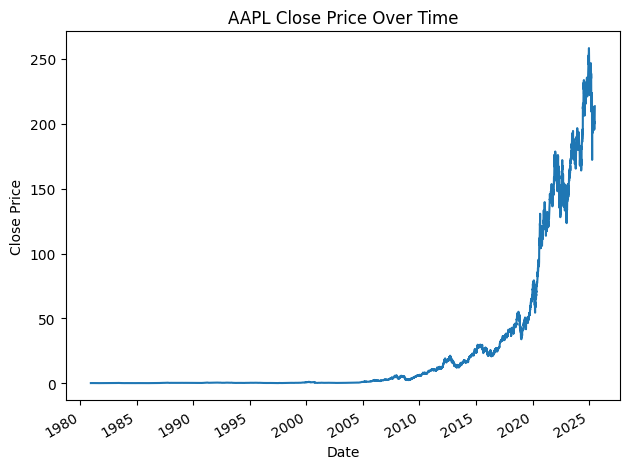

: 

In [ ]:
import matplotlib.pyplot as plt

# 1) filter for AAPL
df_aapl = final_df[final_df["Ticker"] == "AAPL"].set_index("Date")

# 2) plot the Close series in one line
df_aapl["Close"].plot(title="AAPL Close Price Over Time")

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.tight_layout()
plt.show()


In [38]:
import pandas as pd
from datetime import datetime, timedelta

def diagnose_data_freshness(final_df):
    """Diagnose why your data stops at May 20, 2025"""
    
    print("🔍 DATA FRESHNESS DIAGNOSIS")
    print("="*60)
    
    today = pd.Timestamp.now().normalize()
    latest_data = final_df.Date.max()
    earliest_data = final_df.Date.min()
    
    print(f"Today's date: {today.strftime('%Y-%m-%d')}")
    print(f"Latest data: {latest_data.strftime('%Y-%m-%d')}")
    print(f"Data lag: {(today - latest_data).days} days")
    print(f"Dataset span: {earliest_data.strftime('%Y-%m-%d')} to {latest_data.strftime('%Y-%m-%d')}")
    
    # Check each data source's latest date
    print(f"\n📊 DATA SOURCE ANALYSIS:")
    print("-" * 40)
    
    # 1. Stock data (should be most recent)
    stock_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in stock_cols:
        if col in final_df.columns:
            latest_stock = final_df[final_df[col].notna()]['Date'].max()
            lag = (today - latest_stock).days
            print(f"Stock data ({col}): {latest_stock.strftime('%Y-%m-%d')} ({lag} days ago)")
            break
    
    # 2. Macro data sources
    macro_sources = {
        'Fed Funds': 'fedfunds',
        'Treasury 10Y': 'dgs10', 
        'S&P 500': 'growth_snp500_1d',
        'VIX': 'growth_vix_1d',
        'Bitcoin': 'growth_btc_1d',
        'Gold': 'growth_gold_1d'
    }
    
    for source_name, col in macro_sources.items():
        if col in final_df.columns:
            latest_date = final_df[final_df[col].notna()]['Date'].max()
            lag = (today - latest_date).days
            status = "🟢" if lag <= 3 else "🟡" if lag <= 7 else "🔴"
            print(f"{source_name}: {latest_date.strftime('%Y-%m-%d')} ({lag} days ago) {status}")
    
    # 3. Check the limiting factor
    print(f"\n🚨 LIMITING FACTOR ANALYSIS:")
    print("-" * 40)
    
    # Find which source has the earliest cutoff
    source_dates = {}
    
    # Stock data
    for ticker in final_df['Ticker'].unique():
        ticker_data = final_df[final_df['Ticker'] == ticker]
        latest_ticker = ticker_data['Date'].max()
        source_dates[f'{ticker} Stock'] = latest_ticker
    
    # Macro data
    for source_name, col in macro_sources.items():
        if col in final_df.columns:
            latest_macro = final_df[final_df[col].notna()]['Date'].max()
            source_dates[source_name] = latest_macro
    
    # Sort by date to find the limiting factor
    sorted_sources = sorted(source_dates.items(), key=lambda x: x[1])
    
    print("Data sources by latest date (earliest = limiting factor):")
    for source, date in sorted_sources:
        lag = (today - date).days
        is_limiter = "🚨 LIMITING FACTOR" if date == sorted_sources[0][1] else ""
        print(f"  {source}: {date.strftime('%Y-%m-%d')} ({lag} days) {is_limiter}")
    
    return analyze_potential_causes(final_df, sorted_sources[0])

def analyze_potential_causes(final_df, limiting_source):
    """Analyze why the limiting source is outdated"""
    
    source_name, limiting_date = limiting_source
    
    print(f"\n🔧 POTENTIAL CAUSES & SOLUTIONS:")
    print("-" * 40)
    
    causes_and_solutions = [
        {
            "cause": "Market Holiday/Weekend",
            "description": "Markets closed on weekends or holidays",
            "solution": "Normal - wait for next trading day",
            "check": lambda: limiting_date.weekday() >= 5  # Weekend
        },
        {
            "cause": "Data Provider Lag",
            "description": "yfinance or FRED has delayed updates",
            "solution": "Re-run data fetch functions",
            "check": lambda: (pd.Timestamp.now() - limiting_date).days > 3
        },
        {
            "cause": "API Rate Limits",
            "description": "Hit rate limits during data fetching",
            "solution": "Wait and retry, or use API keys",
            "check": lambda: True  # Always possible
        },
        {
            "cause": "Stale Cache",
            "description": "Using cached/old data",
            "solution": "Clear cache and re-fetch",
            "check": lambda: True  # Always possible
        },
        {
            "cause": "Macro Data Lag",
            "description": "FRED data updates with delay",
            "solution": "Use latest available, normal for economic data",
            "check": lambda: 'fed' in source_name.lower() or 'gdp' in source_name.lower()
        }
    ]
    
    print(f"Limiting source: {source_name} (stops at {limiting_date.strftime('%Y-%m-%d')})")
    print("\nPossible causes:")
    
    for i, cause_info in enumerate(causes_and_solutions, 1):
        print(f"\n{i}. {cause_info['cause']}")
        print(f"   Description: {cause_info['description']}")
        print(f"   Solution: {cause_info['solution']}")
    
    return suggest_immediate_actions(final_df, limiting_source)

def suggest_immediate_actions(final_df, limiting_source):
    """Suggest immediate actions to fix data freshness"""
    
    source_name, limiting_date = limiting_source
    
    print(f"\n🚀 IMMEDIATE ACTION PLAN:")
    print("-" * 40)
    
    if 'Stock' in source_name:
        print("1. 📈 REFRESH STOCK DATA:")
        print("   • Re-run: yf.download() for your tickers")
        print("   • Check: Market holidays (NYSE calendar)")
        print("   • Verify: Internet connection")
        
    elif any(x in source_name.lower() for x in ['fed', 'treasury', 'gdp', 'cpi']):
        print("1. 🏦 REFRESH ECONOMIC DATA:")
        print("   • Re-run: pdr.DataReader() for FRED series")
        print("   • Note: Economic data often has 1-3 day delay")
        print("   • Check: FRED website for update schedules")
        
    elif any(x in source_name.lower() for x in ['bitcoin', 'gold', 'vix']):
        print("1. 📊 REFRESH MARKET DATA:")
        print("   • Re-run: yf.download() for market indices")
        print("   • Check: Specific asset trading hours")
        print("   • Verify: Asset still trading (not delisted)")
    
    print(f"\n2. 🔄 QUICK FIX OPTIONS:")
    print("   a) Re-run your entire macro pipeline")
    print("   b) Update just the stale data source")
    print("   c) Use data as-is (May 20 might be acceptable)")
    print("   d) Filter to complete data periods only")
    
    print(f"\n3. 📋 VERIFICATION STEPS:")
    print("   • Check original data sources manually")
    print("   • Verify today's date/timezone settings")
    print("   • Test with a single ticker first")
    
    return True

# Run the diagnosis
if 'final_df' in locals():
    diagnose_data_freshness(final_df)
else:
    print("❌ final_df not found. Run your macro pipeline first!")
    
    # Alternative: Check your source data
    if 'augmented_df' in locals():
        print("\n📊 Checking augmented_df instead...")
        diagnose_data_freshness(augmented_df)
    elif 'stocks_df' in locals():
        print("\n📊 Checking stocks_df instead...")
        print(f"stocks_df latest date: {stocks_df['Date'].max()}")
        print(f"This might be your bottleneck!")

print(f"\n💡 TIP: Most likely cause is that one data source")
print(f"   (stock data, FRED, or yfinance) hasn't updated since May 20.")

🔍 DATA FRESHNESS DIAGNOSIS
Today's date: 2025-07-06
Latest data: 2025-05-20
Data lag: 47 days
Dataset span: 1980-12-12 to 2025-05-20

📊 DATA SOURCE ANALYSIS:
----------------------------------------
Stock data (Open): 2025-05-20 (47 days ago)
Fed Funds: 2025-05-20 (47 days ago) 🔴
Treasury 10Y: 2025-05-20 (47 days ago) 🔴
S&P 500: 2025-05-20 (47 days ago) 🔴
VIX: 2025-05-20 (47 days ago) 🔴
Bitcoin: 2025-05-20 (47 days ago) 🔴
Gold: 2025-05-20 (47 days ago) 🔴

🚨 LIMITING FACTOR ANALYSIS:
----------------------------------------
Data sources by latest date (earliest = limiting factor):
  AAPL Stock: 2025-05-20 (47 days) 🚨 LIMITING FACTOR
  MSFT Stock: 2025-05-20 (47 days) 🚨 LIMITING FACTOR
  Fed Funds: 2025-05-20 (47 days) 🚨 LIMITING FACTOR
  Treasury 10Y: 2025-05-20 (47 days) 🚨 LIMITING FACTOR
  S&P 500: 2025-05-20 (47 days) 🚨 LIMITING FACTOR
  VIX: 2025-05-20 (47 days) 🚨 LIMITING FACTOR
  Bitcoin: 2025-05-20 (47 days) 🚨 LIMITING FACTOR
  Gold: 2025-05-20 (47 days) 🚨 LIMITING FACTOR

🔧 POTE

In [39]:
import yfinance as yf
import pandas as pd
import pandas_datareader.data as pdr
from datetime import datetime, timedelta

def test_live_data_availability():
    """Test if fresh data is available from your sources"""
    
    print("🔍 TESTING LIVE DATA AVAILABILITY")
    print("="*50)
    
    today = pd.Timestamp.now()
    
    # Test 1: Stock data freshness
    print("1. 📈 TESTING STOCK DATA:")
    print("-" * 30)
    
    tickers = ['AAPL', 'MSFT']
    for ticker in tickers:
        try:
            # Get last 10 days of data
            fresh_data = yf.download(ticker, period="10d", progress=False)
            if not fresh_data.empty:
                latest_date = fresh_data.index.max()
                days_old = (today - latest_date).days
                status = "🟢 Fresh" if days_old <= 3 else "🟡 Stale" if days_old <= 7 else "🔴 Very Stale"
                
                print(f"  {ticker}: {latest_date.strftime('%Y-%m-%d')} ({days_old} days old) {status}")
                
                # Show latest price
                latest_close = fresh_data['Close'].iloc[-1]
                print(f"    Latest Close: ${latest_close:.2f}")
            else:
                print(f"  {ticker}: ❌ No data available")
                
        except Exception as e:
            print(f"  {ticker}: ❌ Error: {e}")
    
    # Test 2: Macro data freshness  
    print(f"\n2. 🏦 TESTING MACRO DATA:")
    print("-" * 30)
    
    macro_tests = {
        'Fed Funds': 'FEDFUNDS',
        'Treasury 10Y': 'DGS10',
        'S&P 500': '^GSPC'
    }
    
    for name, symbol in macro_tests.items():
        try:
            if symbol.startswith('^'):
                # yfinance data
                fresh_data = yf.download(symbol, period="10d", progress=False)
                source = "yfinance"
            else:
                # FRED data
                end_date = datetime.now()
                start_date = end_date - timedelta(days=30)
                fresh_data = pdr.DataReader(symbol, "fred", start=start_date, end=end_date)
                source = "FRED"
            
            if not fresh_data.empty:
                latest_date = fresh_data.index.max()
                days_old = (today - latest_date).days
                status = "🟢 Fresh" if days_old <= 3 else "🟡 Stale" if days_old <= 7 else "🔴 Very Stale"
                
                print(f"  {name}: {latest_date.strftime('%Y-%m-%d')} ({days_old} days old) {status} [{source}]")
                
                # Show latest value
                if symbol.startswith('^'):
                    latest_val = fresh_data['Close'].iloc[-1]
                    print(f"    Latest Close: ${latest_val:.2f}")
                else:
                    latest_val = fresh_data.iloc[-1, 0]
                    print(f"    Latest Value: {latest_val:.2f}")
            else:
                print(f"  {name}: ❌ No data available [{source}]")
                
        except Exception as e:
            print(f"  {name}: ❌ Error: {e}")
    
    return True

def check_your_original_data():
    """Check if your original stocks_df is the bottleneck"""
    
    print(f"\n🔍 CHECKING YOUR ORIGINAL DATA")
    print("="*50)
    
    if 'stocks_df' in globals():
        print("stocks_df found! Checking date range...")
        latest = stocks_df['Date'].max()
        earliest = stocks_df['Date'].min()
        
        print(f"  Original stocks_df range: {earliest} to {latest}")
        print(f"  Days old: {(pd.Timestamp.now() - latest).days}")
        
        if latest < pd.Timestamp('2025-07-01'):
            print("  🚨 FOUND THE PROBLEM: Your original stocks_df is stale!")
            print("  📋 Solution: Re-download fresh stock data")
        else:
            print("  ✅ stocks_df looks current")
            
    else:
        print("❌ stocks_df not found in current environment")
    
    if 'augmented_df' in globals():
        print(f"\naugmented_df found! Checking date range...")
        latest = augmented_df['Date'].max()
        print(f"  augmented_df latest: {latest}")
        print(f"  Days old: {(pd.Timestamp.now() - latest).days}")
    
    return True

def create_fresh_dataset():
    """Create a fresh dataset with current data"""
    
    print(f"\n🔄 CREATING FRESH DATASET")
    print("="*50)
    
    # Download fresh stock data
    tickers = ['AAPL', 'MSFT']
    fresh_stocks = []
    
    for ticker in tickers:
        print(f"Downloading fresh {ticker} data...")
        try:
            # Get max period for historical analysis
            stock_data = yf.download(ticker, period="max", progress=False)
            
            if not stock_data.empty:
                # Reset index to get Date as column
                stock_data = stock_data.reset_index()
                stock_data['Ticker'] = ticker
                
                # Reorder columns
                cols = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']
                if 'Adj Close' in stock_data.columns:
                    cols.append('Adj Close')
                
                stock_data = stock_data[cols]
                fresh_stocks.append(stock_data)
                
                print(f"  ✅ {ticker}: {len(stock_data)} rows, latest: {stock_data['Date'].max().strftime('%Y-%m-%d')}")
            else:
                print(f"  ❌ {ticker}: No data downloaded")
                
        except Exception as e:
            print(f"  ❌ {ticker}: Error - {e}")
    
    if fresh_stocks:
        # Combine all stocks
        fresh_stocks_df = pd.concat(fresh_stocks, ignore_index=True)
        
        print(f"\n✅ Fresh stock dataset created:")
        print(f"  Shape: {fresh_stocks_df.shape}")
        print(f"  Date range: {fresh_stocks_df['Date'].min()} to {fresh_stocks_df['Date'].max()}")
        print(f"  Tickers: {', '.join(fresh_stocks_df['Ticker'].unique())}")
        
        return fresh_stocks_df
    else:
        print("❌ Failed to create fresh dataset")
        return None

# Run the tests
print("🚀 RUNNING FRESH DATA DIAGNOSTICS")
print("="*60)

# Test 1: Check live data availability
test_live_data_availability()

# Test 2: Check your original data
check_your_original_data()

# Test 3: Offer to create fresh dataset
print(f"\n❓ NEXT STEPS:")
print("-" * 20)
print("1. If live data shows fresh dates → Your original stocks_df is stale")
print("2. Re-download stocks_df with current data")
print("3. Re-run your TA and macro pipelines")
print("4. Should get data through July 2025")

print(f"\n🔧 Want to create fresh dataset? Uncomment the line below:")
print("# fresh_stocks_df = create_fresh_dataset()")

# Uncomment this line if you want to create fresh data immediately:
# fresh_stocks_df = create_fresh_dataset()

🚀 RUNNING FRESH DATA DIAGNOSTICS
🔍 TESTING LIVE DATA AVAILABILITY
1. 📈 TESTING STOCK DATA:
------------------------------


C:\Users\drish\AppData\Local\Temp\ipykernel_23108\559776921.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fresh_data = yf.download(ticker, period="10d", progress=False)


  AAPL: 2025-07-03 (3 days old) 🟢 Fresh
  AAPL: ❌ Error: unsupported format string passed to Series.__format__


C:\Users\drish\AppData\Local\Temp\ipykernel_23108\559776921.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fresh_data = yf.download(ticker, period="10d", progress=False)


  MSFT: 2025-07-03 (3 days old) 🟢 Fresh
  MSFT: ❌ Error: unsupported format string passed to Series.__format__

2. 🏦 TESTING MACRO DATA:
------------------------------
  Fed Funds: ❌ No data available [FRED]
  Treasury 10Y: 2025-07-02 (4 days old) 🟡 Stale [FRED]
    Latest Value: 4.30


C:\Users\drish\AppData\Local\Temp\ipykernel_23108\559776921.py:53: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fresh_data = yf.download(symbol, period="10d", progress=False)


  S&P 500: 2025-07-03 (3 days old) 🟢 Fresh [yfinance]
  S&P 500: ❌ Error: unsupported format string passed to Series.__format__

🔍 CHECKING YOUR ORIGINAL DATA
stocks_df found! Checking date range...
  Original stocks_df range: 1980-12-12 00:00:00 to 2025-05-20 00:00:00
  Days old: 47
  🚨 FOUND THE PROBLEM: Your original stocks_df is stale!
  📋 Solution: Re-download fresh stock data

augmented_df found! Checking date range...
  augmented_df latest: 2025-05-20 00:00:00
  Days old: 47

❓ NEXT STEPS:
--------------------
1. If live data shows fresh dates → Your original stocks_df is stale
2. Re-download stocks_df with current data
3. Re-run your TA and macro pipelines
4. Should get data through July 2025

🔧 Want to create fresh dataset? Uncomment the line below:
# fresh_stocks_df = create_fresh_dataset()
